# DC$\pi$BO - Real World Example: Predator-Prey System (ODE)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../../data/")
sys.path.append("../..")

from src.examples.example_setups import setup_plankton_SEM
from src.utils.sem_utils.real_sems import PredatorPreySEM
from src.utils.sem_utils.sem_estimate import build_sem_hat

from src.experimental.experiments_ode import create_plankton_dataset

from src.experimental.experiments_ode import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial
from src.utils.plotting import plot_expected_opt_curve_paper

from src.methods.bo_ode import BO
from src.methods.dcbo_ode import DCBO
from src.methods.pibo_ode import PIBO
from src.methods.dcpibo_ode import DCPIBO

from matplotlib.pyplot import rc
import numpy as np
from scipy import stats
import random

random.seed(42)

## Utility Functions

In [2]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [3]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [4]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [5]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [6]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Constants and such

In [7]:
T = 4
t_axis = np.linspace(1,T,T,dtype=int)
N = 20
std = 0.1
beta = 1

## Optima location

### Good prior

In [8]:
a_param = 0
b_param = 0
y = a_param*t_axis+b_param # the line on which I assume the optima would be

### Bad prior

In [9]:
bad_a_param = 6
bad_y_param = 4
bad_y = bad_a_param*t_axis+bad_y_param

## Setup

### Good prior

In [10]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

### Bad prior

In [11]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)

bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

### Model:

In [12]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects = setup_plankton_SEM(T=T)

 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars


In [13]:
manipulative_vars = list(intervention_domain.keys())

In [14]:
observation_samples = create_plankton_dataset(1,N+1)

## Models' execution

In [15]:
R = 3

### Good Prior

In [16]:
good_results = run_methods_replicates(G=G, 
                                sem=PredatorPreySEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='D',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = observation_samples,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 5, # The method samples 5 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                manipulative_variables=manipulative_vars)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:01,  2.09it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  2.13it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:01<00:00,  2.42it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:01,  2.91it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  3.15it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  3.13it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead o


	>>>DCBO



 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/li


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:17, 25.95


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.27it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.10it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.17it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.12it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  3.96it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  3.92it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  3.98it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:15, 25.19


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarn


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.63it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.39it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.48it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.37it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.26it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.36it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.37it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:15, 25.04


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:16, 25.66

### Bad prior

In [17]:
bad_results = run_methods_replicates(G=G, 
                                sem=PredatorPreySEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='D',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = observation_samples,
                                exploration_sets = exploration_sets,
                                priors_regret = bad_predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 5, # The method samples 5 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                manipulative_variables=manipulative_vars)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.57it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.35it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.08it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  3.99it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.13it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.18it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:24<01:14, 24.77


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:26<01:18, 26.06


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.44it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.17it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  3.95it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.17it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.36it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.27it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:15, 25.04


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:26<01:18, 26.13


	>>>BO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/real_sems.py:55: RuntimeWarning:invalid value encountered in double_scalars

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.66it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.55it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.46it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39it/s]


20

	>>>PIBO




Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:00<00:00,  4.13it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  50%|████████████████████████████████████▌                                    | 2/4 [00:00<00:00,  4.22it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  75%|██████████████████████████████████████████████████████▊                  | 3/4 [00:00<00:00,  4.35it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.33it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:24<01:14, 24.89


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply

Time index:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  25%|██████████████████▎                                                      | 1/4 [00:25<01:17, 25.95

## Plotting

In [18]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

### Good prior

In [19]:
good_data = get_relevant_results(results=good_results, replicates=R)
good_exp_optimal_outcome_values_during_trials, good_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=good_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

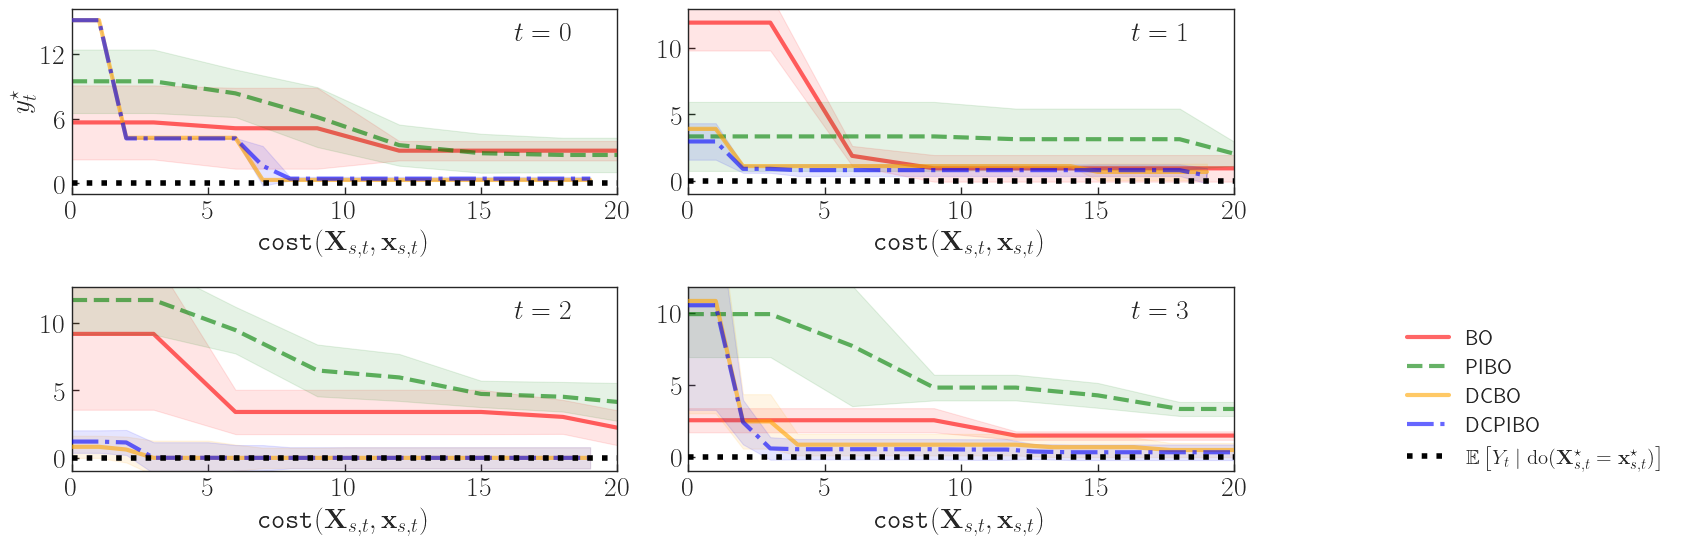

In [20]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    good_exp_per_trial_cost,
    good_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Bad prior

In [21]:
bad_data = get_relevant_results(results=bad_results,replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=bad_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

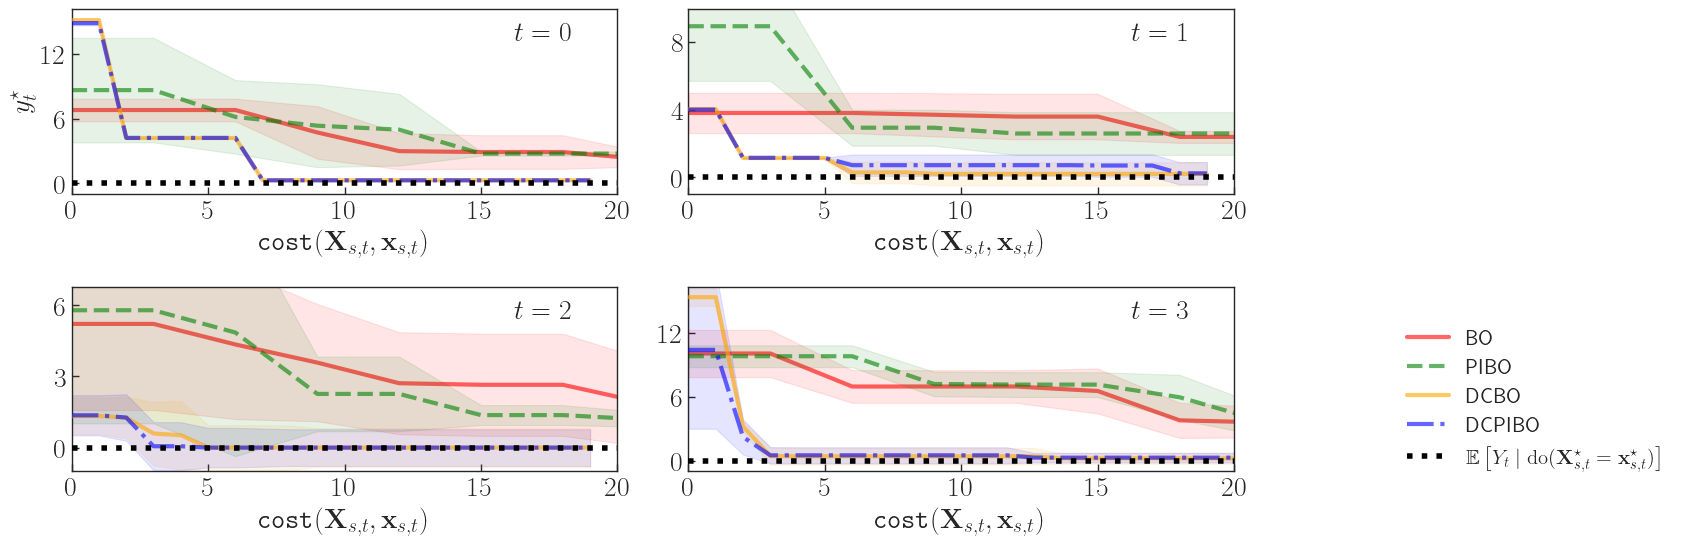

In [22]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

## Gap Metric

In [23]:
def compute_gap_values(T, summary):
    G_BO=0
    G_PIBO=0
    G_DCBO=0
    G_DCPIBO=0
    list_gaps=[]
    summary_list = list(summary.values())
    for i in range(len(summary_list)):
        for t in range(T):
            # print(summary_list[i][t][0])
            if i==0:
                G_BO=G_BO+summary_list[i][t][0]
                if t==3:
                    list_gaps.append(G_BO/T)
            elif i==1:
                G_PIBO=G_PIBO+summary_list[i][t][0]
                if t==3:
                    list_gaps.append(G_PIBO/T)
            elif i==2:
                G_DCBO=G_DCBO+summary_list[i][t][0]
                if t==3:
                    list_gaps.append(G_DCBO/T)
            elif i==3:
                G_DCPIBO=G_DCPIBO+summary_list[i][t][0]
                if t==3:
                    list_gaps.append(G_DCPIBO/T)
    return list_gaps

### Good Gap Metric

In [24]:
good_t_i_l = get_common_initial_values(T=T,
                                  data=good_data,
                                  n_replicates=R)

good_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                           exp_optimal_outcome_values_during_trials=good_exp_optimal_outcome_values_during_trials,
                           n_trials=N,
                           T=T,
                           n_decimal=1)

good_summary = gap_metric_standard(T=T,
                             data=good_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = good_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=good_w_c_d)

good_list = compute_gap_values(T, good_summary)

In [25]:
good_summary

{'BO': [[0.46614502064074986, 0.024201984451421767],
  [0.483418398200181, 0.02383292046507193],
  [0.4743088347219901, 0.023857242330755923],
  [0.46875081176830097, 0.01282383677104905]],
 'PIBO': [[0.47345647137833646, 0.014502023957931143],
  [0.45754218647290884, 0.02418587499578876],
  [0.4792356310133727, 0.01594065060284675],
  [0.4398412296732414, 0.03764399751103787]],
 'DCBO': [[0.5022377565211086, 0.0012443702834065296],
  [0.4763033487037244, 0.026467571727775495],
  [0.9457784035768172, 0.004157144605796234],
  [0.495659708723516, 0.012179468785682464]],
 'DCPIBO': [[0.49814817990200266, 0.005768761551292521],
  [0.4886774567753844, 0.028456262118793166],
  [0.9442547953760382, 0.005401713340035193],
  [0.5007505246707774, 0.015010018036776254]]}

In [26]:
good_list

[0.4731557663328055,
 0.46251887963446486,
 0.6049948043812916,
 0.6079577391810507]

### Bad Gap Metric

In [27]:
bad_t_i_l = get_common_initial_values(T=T,
                                  data=bad_data,
                                  n_replicates=R)

bad_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                          exp_optimal_outcome_values_during_trials=bad_exp_optimal_outcome_values_during_trials,
                          n_trials=N,
                          T=T,
                          n_decimal=1)

bad_summary = gap_metric_standard(T=T,
                             data=bad_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = bad_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=bad_w_c_d)

bad_list = compute_gap_values(T, bad_summary)

In [28]:
bad_summary

{'BO': [[0.4543670533042376, 0.006810963250695413],
  [0.4114619059897644, 0.07649987550295027],
  [0.4666052625443351, 0.023909385080342613],
  [0.460678311998086, 0.01649554020407469]],
 'PIBO': [[0.4711867620362968, 0.013982984577850415],
  [0.4687967806717908, 0.029808750480578336],
  [0.4672462372440909, 0.018011784080078107],
  [0.48397125456568396, 0.036785293194031746]],
 'DCBO': [[0.503179200608773, 0.0010201697365723498],
  [0.49528164764914323, 0.024803700993984188],
  [0.86859508163247, 0.033009517036147656],
  [0.5031658579121346, 0.013653743911460462]],
 'DCPIBO': [[0.503282916835575, 0.0005078626035747295],
  [0.4946023607925893, 0.025764357679264507],
  [0.8811285964722165, 0.018778318585102313],
  [0.5032267390282565, 0.013567645011348455]]}

In [29]:
bad_list

[0.4482781334591058,
 0.4728002586294656,
 0.5925554469506302,
 0.5955601532821594]